# 2020 02 13
## Testing prpa cin senders and cin pulser/receivers  
25nM rpa ahl
1mM iptg
37C

In [2]:
import os
import sys
import time
import datetime
import re
import multiprocessing
import ast

import numpy as np
import matplotlib.colors as mpl_colors
import matplotlib.pyplot as plt
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}

sns.set(rc=rc)

from scipy import ndimage as ndi
import scipy as scp
import pandas as pd

import matplotlib.animation as anm
from IPython.display import HTML

from skimage.external.tifffile import TiffWriter

from PIL import Image

import skimage.filters
import skimage.io
import skimage.morphology
import skimage.feature
import skimage.exposure

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh import palettes, transform

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 24, 
      'xtick.labelsize': 18, 
      'ytick.labelsize': 18, 
      'legend.fontsize': 18,
      'axes.facecolor': 'fbfbfc'}
sns.set_context('talk', rc=rc)

%load_ext line_profiler

%matplotlib inline
output_notebook()

# you need to populate image lists from the two folders

# file_temp = "/mnt/disks/movie-181208/180827_1/{}/img_{:09d}_{}_000.tif"

Loading BokehJS ...

In [3]:
# Channel information for IX81 inverted microscope
all_channel_inds = [str(xx) for xx in range(6)]
all_channel_names = ['Brightfield', 'GFP', 'YFP', 'mScarlet', 'unk', 'sfCFP']
all_channel_dict = dict(zip(all_channel_inds, all_channel_names))

def img_metadata_dict(img):
    '''Read metadata into dictionary from the TIFF metadata. 
    
        This function uses string replacements to read dictionary key-value pairs.
    
    '''
    metadata_key = 50839
    metadata_str = img.tag[metadata_key].decode('utf-8').replace("\x00","")
    splits = re.split(",",metadata_str)
    metadata_keys = []
    metadata_vals = []
    for split_x in splits:
        hits = re.findall(r"(?<=\").*?(?=\")", split_x)
        if len(hits) == 3:
            key, _, val = [hit.replace("'","").strip() for hit in hits]
            metadata_keys.append(key)
            metadata_vals.append(val)
    return dict(zip(metadata_keys, metadata_vals))

def img_metadata_dict_full(img):
    '''Read metadata into dictionary from the TIFF metadata. 
    
        After some cleanup, this function reads the metadata string directly as a dictionary definition.
    '''
    metadata_key = 50839
    metadata_str = img.tag[metadata_key].decode('utf-8').replace("\x00","")
    in_str = metadata_str[9:].replace('\n','').replace('\s*','').replace('null','None').replace('false','False').replace('true','True')
    out_dict = ast.literal_eval(in_str)
    return out_dict

def img_metadata(img):
    '''Read creation time from the TIFF metadata in seconds from Epoch'''
    metadata = img_metadata_dict(img)
    time_tuple = time.strptime(metadata['Time'],r"%Y-%m-%d %H:%M:%S %z")
    return time.mktime(time_tuple), metadata["Channel"]

def fn_metadata(fn):
    '''Wrapper for reading creation time from an image filename'''
    with Image.open(fn) as img:
        out = img_metadata(img)
    return out

def fn_metadata_full(fn):
    '''Wrapper for reading full metadata dictionary from a filename'''
    with Image.open(fn) as img:
        out = img_metadata_dict_full(img)
    return out

def get_time_vector_from_fn(fn):
    time_dict = dict(zip(channel,len(channel)*[]))
    with Image.open(fn) as img:
        try:
            while 1:
                ct, ch = img_metadata(img)
                time_dict[chan_dict[ch]].append(ct)
                img.seek(img.tell()+1)
        except EOFError:
            pass
        except ValueError:
            pass
        except SyntaxError:
            pass
    return time_dict

def get_data_from_frame(img):
    ct, ch = img_metadata(img)
    im_arr = np.array(list(img.getdata()),dtype=np.uint16).reshape(img.size[::-1])
    return ct, ch, im_arr

def get_movie_from_img(img):
    img_dict = dict(zip(channel,len(channel)*[]))
    time_dict = dict(zip(channel,len(channel)*[]))
    try:
        img.seek(0)
        while 1:
            ct, ch, im_arr = get_data_from_frame(img)
            ch = chan_dict[ch]
            img_dict[ch].append(im_arr)
            time_dict[ch].append(ct)
            img.seek(img.tell()+1)
    except EOFError:
        pass
    except ValueError:
        pass
    except SyntaxError:
        pass
    for key in img_dict:
        h, w = im_arr.shape
        img_dict[key] = np.vstack([x.reshape((1, h, w, 1)) for x in img_dict[key]])
    return img_dict, time_dict

def read_img(fn):
    with Image.open(fn) as img:
        return get_movie_from_img(img)
        
def concat_img_files(fn_list, fn_out):
    keep_keys = ['Channel', 'Time', 'PositionName']
    metadata = dict(zip(keep_keys, keep_keys))
    i = 0
    #ct = datetime.datetime.fromtimestamp(ctime(fn))
    with TiffWriter(fn_out, bigtiff=True) as tif:
        for fn in fn_list:
            eof_flag = True
            print("Writing ", fn)
            with Image.open(fn) as img:
                while eof_flag:
                    _, _, im_arr = get_data_from_frame(img)
                    img_md = img_metadata_dict(img)
                    for k in keep_keys:
                        metadata[k] = img_md[k]
                    metadata['Frame'] = int(os.path.basename(fn).split("_")[1])
                    h, w = im_arr.shape
                    tif.save(im_arr, metadata=metadata.copy())
                    try:
                        i += 1
                        img.seek(img.tell()+1)
                    except:
                        eof_flag = False
        
def convert_img_file(fn, fn_out):
    dirname = os.path.dirname(fn)
    fn_out = os.path.join(dirname, fn_out)
    ct = datetime.datetime.fromtimestamp(ctime(fn))
    eof_flag = True
    with Image.open(fn) as img:
        with TiffWriter(fn_out, bigtiff=True) as tif:
            while eof_flag:
                _, _, im_arr = get_data_from_frame(img)
                metadata = img_metadata_dict(img)
                tif.save(im_arr, datetime=ct, metadata=metadata)
                try:
                    img.seek(img.tell()+1)
                except:
                    eof_flag = False
    
def process_file(fn, skip=0):
    with Image.open(fn) as img:
        eof_flag = True
        column_names = ('time', 'colony', 'sfcfp', 'mscarlet', 'col_size', 'sfcfp_bg', 'mscarlet_bg')
        df = pd.DataFrame(columns = column_names)
        try:
            while eof_flag:
                acq_dict = {}
                for i in range(3):
                    ct, ch, im_arr = get_data_from_frame(img)
#                     ch = chan_dict[ch]
                    acq_dict[ch] = (ct, im_arr)
                    try:
                        img.seek(img.tell()+1)
                    except EOFError:
                        eof_flag = False
                rfps, cfps, sizes, num, cfp_bg, rfp_bg = get_fluors(acq_dict['3'][1], acq_dict['5'][1], acq_dict['0'][1])
                for col_i in range(num):
                    df_dict = dict(zip(column_names, [[ct], [col_i], [cfps[col_i]], [rfps[col_i]], [sizes[col_i]], [cfp_bg], [rfp_bg]]))
                    df = df.append(pd.DataFrame(df_dict), ignore_index=True)
                try:
                    img.seek(img.tell()+3*skip)
                except EOFError:
                    eof_flag = False
        except EOFError:
            pass
        except ValueError:
            pass
        except SyntaxError:
            pass
        df.to_csv(fn+".csv")
    return df

    
def process_file_skimage(fn):
    time_vec = get_time_vector_from_fn(fn)['"Brightfield"']
    im = skimage.io.imread(fn)
    column_names = ('time', 'colony', 'sfcfp', 'mscarlet', 'col_size', 'sfcfp_bg', 'mscarlet_bg')
    df = pd.DataFrame(columns = column_names)
    try:
        while eof_flag:
            acq_dict = {}
            for i in range(3):
                ct, ch, im_arr = get_data_from_frame(img)
                acq_dict[ch] = (ct, im_arr)
                try:
                    img.seek(img.tell()+1)
                except EOFError:
                    eof_flag = False
            rfps, cfps, sizes, num, cfp_bg, rfp_bg = get_fluors(acq_dict['3'][1], acq_dict['5'][1], acq_dict['0'][1])
            for col_i in range(num):
                df_dict = dict(zip(column_names, [[ct], [col_i], [cfps[col_i]], [rfps[col_i]], [sizes[col_i]], [cfp_bg], [rfp_bg]]))
                df = df.append(pd.DataFrame(df_dict), ignore_index=True)
    except EOFError:
        pass
    except ValueError:
        pass
    except SyntaxError:
        pass
    except KeyError:
        pass
    df.to_csv(fn+".csv")
    return df

def ctime(fname):
    '''Read creation time from the TIFF metadata in seconds from Epoch'''
    metadata_key = 50839
    with Image.open(fname) as img:
        metadata_str = img.tag_v2[50839].decode('utf-8').replace("\x00","")
    splits = re.split(",",metadata_str)
    metadata_keys = []
    metadata_vals = []
    for split_x in splits:
        hits = re.findall(r"(?<=\").*?(?=\")", split_x)
        if len(hits) == 3:
            key, _, val = [hit.replace("'","").strip() for hit in hits]
            metadata_keys.append(key)
            metadata_vals.append(val)
    metadata = dict(zip(metadata_keys, metadata_vals))

    time_tuple = time.strptime(metadata['Time'][:-6],r"%Y-%m-%d %H:%M:%S")
    return time.mktime(time_tuple)

def crop(img):
    w, h = img.shape
    if w > 1000:
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))*2
    else:
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))
    return(img[y1:y2,x1:x2])

def uncrop(img):
    w, h = img.shape
    if w > 800:
        out_img = np.zeros((512*2, 672*2))
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))*2
    else:
        out_img = np.zeros((512, 672))
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))
    out_img[y1:y2,x1:x2] = img
    return(out_img)

def label_image(im_arr):
    im_arr = im_arr.astype(np.float32).astype(np.uint16) / 65535
    w, h = im_arr.shape

    # Convert the uneven image to floating point
    im_float = im_arr
    # Smooth to reduce noise
    g_radius = 5
    im_smooth = skimage.filters.gaussian(im_float, g_radius)
    im_bgsub = im_float - im_smooth

    # Perform the median filter
    selem = skimage.morphology.square(4)
    im_bgsub = skimage.filters.median(im_bgsub, selem) / 4096.0
    
    # Adjust exposure
    im_adj = skimage.exposure.equalize_adapthist(im_bgsub)

    # Edge detection
    im_edge = skimage.filters.sobel(im_adj)
    im_edge = skimage.exposure.equalize_adapthist(im_adj)

    # Remove small objects and fill holes
    if np.all(im_edge == im_edge[0,0]) or np.any(np.isnan(im_edge)):
        return np.zeros((w,h)), 1
    thresh = skimage.filters.threshold_otsu(im_edge)
    selem = skimage.morphology.square(2)
    im_bw = skimage.morphology.binary_dilation(im_edge > thresh, selem)
    selem = skimage.morphology.square(12)
    im_bw = skimage.morphology.binary_closing(im_bw, selem)
    
    im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=10)
    im_labeled, num = skimage.morphology.label(im_bw, return_num=True)
    return im_labeled, num

def get_fluors(bfi, rfp, gfp):
    im_labeled, num = label_image_2(bfi)
    num  = im_labeled.max()
#     rfp, gfp = [crop(x) for x in [rfp, gfp]]
    gfps = [np.mean(gfp[im_labeled == x]) for x in np.arange(1,num+1)]
    rfps = [np.mean(rfp[im_labeled == x]) for x in np.arange(1,num+1)]
    gfp_bg = np.mean(gfp[im_labeled == 0])
    rfp_bg = np.mean(rfp[im_labeled == 0])
    sizes = [np.sum(im_labeled == x) for x in np.arange(1,num+1)]
    return rfps, gfps, sizes, num, gfp_bg, rfp_bg

def read_tiff_file(fn, skip=0):
    print("Begin " + fn)
    df = process_file(fn, skip=skip)
    df.to_csv(fn+".csv", index=False)
    print("Finished " + fn)

def par_worker(fn_list, skip=1):
    for fn in fn_list:
        read_tiff_file(fn, skip=skip)
    

In [4]:
def ctime_parworker(fn_list, out_fn):
    n_fn = len(fn_list)
    ctime_vec = [ctime(xx) for xx in fn_list]
    index = pd.Index(data=fn_list, copy=True, name=b'fn')
    out_series = pd.Series(ctime_vec, index=index, name='time')
    out_series.to_csv(out_fn)
    
def ctime_parallel_wrapper(img_files):
    n_proc = 4
    sub_lists = [img_files[i::n_proc] for i in np.arange(n_proc)]
    out_fn_list = ['sub_time_{}.csv'.format(xx) for xx in np.arange(n_proc)]
    worker_inputs = zip(sub_lists, out_fn_list)
    with multiprocessing.Pool(n_proc) as pool:
        pool.starmap(ctime_parworker, worker_inputs)

def ctime_parallel_read_result(img_files):
    fn_list = [xx for xx in os.listdir() if 'sub_time' in xx]
    series = pd.concat([pd.read_csv(fn, index_col=0, header=None,names=['fn','time'],squeeze=True) for fn in fn_list])
#     series.index = [os.path.abspath(xx) for xx in series.index]
    return series.loc[img_files].values

super_dir = '../img_1'
pos_dirs = [os.path.join(super_dir, xx) for xx in os.listdir(super_dir) if os.path.isdir(os.path.join(super_dir, xx))]
img_files = [os.path.join(pos_dir, xx) for pos_dir in pos_dirs for xx in os.listdir(pos_dir) if '.tif' in xx]
# ctime_parallel_wrapper(img_files)
time_vec = ctime_parallel_read_result(img_files)
time_vec = time_vec - time_vec.min()
np.save('timevec.npy',time_vec)

In [5]:
# Extract movie metadata
all_metadata = fn_metadata_full(img_files[0])
summ_dict = all_metadata['Summary']
chan_ind = summ_dict['ChNames']
chan_int = [int(xx) for xx in chan_ind]
n_chan = len(chan_ind)
chan_int_dict = dict(zip(chan_int, np.arange(n_chan)))
chan_name = [all_channel_dict[xx] for xx in chan_ind]
n_pos = len(pos_dirs)#summ_dict['Positions']
im_width = summ_dict['Width']
im_height = summ_dict['Height']

In [6]:
img_files[0]

'../img_1/3-Pos_016_001/img_000000041_2_000.tif'

In [7]:
img_re_pattern = r'{}/(?P<pad>[0-9]+)-Pos_(?P<padcol>[0-9]+)_(?P<padrow>[0-9]+)/img_(?P<frame>[0-9]*)_(?P<channel>[0-9]*)_000.tif'.format(super_dir)
rem = re.findall(img_re_pattern, '\n'.join(img_files), re.MULTILINE)
rem_arr = np.array(rem)
rem_arr[rem_arr==''] = -1
metadata_arr = rem_arr.astype(np.int)
n_rows = metadata_arr.shape[0]
pad_vec, padcol_vec, padrow_vec, frame_vec, channel_vec = metadata_arr.T
# padpos_vec = padpos_vec1 + padpos_vec2
pad_vec = pad_vec - np.min(pad_vec)
time_vec = np.load('timevec.npy')
pos_vec = np.empty(n_rows,dtype=np.int)
padpos_vec = np.empty(n_rows,dtype=np.int)

In [8]:
n_frames = np.max(frame_vec)+1

columns = ['pos','pad','padcol','padrow','frame','channel','fn','time']
col_data = [pos_vec, pad_vec, padcol_vec, padrow_vec, frame_vec, channel_vec, img_files, time_vec]
n_rows = len(img_files)
n_pads = len(np.unique(pad_vec))

# files_df = pd.read_csv('filesdf.csv')

files_df = pd.DataFrame(
    dict(zip(columns, col_data)))
files_df = files_df.sort_values(by='time')
files_df = files_df.loc[files_df.frame<n_frames,:]
# gb_pp = files_df.groupby('pad')
# for i, inds in enumerate(gb_pp.groups.values()):
#     files_df.loc[inds,'pos'] = i
gb_pp = files_df.groupby(['padcol','padrow'])
for i, inds in enumerate(gb_pp.groups.values()):
    files_df.loc[inds,'padpos'] = i
files_df.loc[:,'pos'] = np.tile(np.repeat(np.arange(n_pos), n_chan), n_frames)

# def pad_helper_fn(pos):
#     pad_lims = np.array([8,19,32,44,56])
#     pad_inds = np.arange(len(pad_lims))
#     return np.min(pad_inds[pad_lims > pos])

# files_df.loc[:,'pad'] = np.array([pad_helper_fn(xx) for xx in files_df.pos.values])

pos_df = files_df.loc[:,['pos','pad']].groupby('pos').agg(np.min)
files_df.to_csv('filesdf.csv',index=False)

In [9]:
files_df = pd.read_csv('filesdf.csv')
gb_frame = files_df.groupby('frame')
sub_len = np.array([xx[1].shape[0] for xx in gb_frame])
frames = np.array([xx for xx in gb_frame.groups])

max_frame = frames[1:][np.diff(sub_len)==0].max()
files_df = files_df.loc[files_df.frame<=max_frame,:]

n_pads = len(np.unique(files_df.pad))
n_frames = np.max(files_df.frame)+1
pos_df = files_df.loc[:,['pos','pad']].groupby('pos').agg(np.min)

In [10]:
label_vec = [xx['Label'] for xx in summ_dict['InitialPositionList']]
xy_vec = [xx['DeviceCoordinatesUm']['XYStage'] for xx in summ_dict['InitialPositionList']]
lab_xy_dict = dict(zip(label_vec, xy_vec))
# [xx.split('/')[2] for xx in tmp_df.fn]

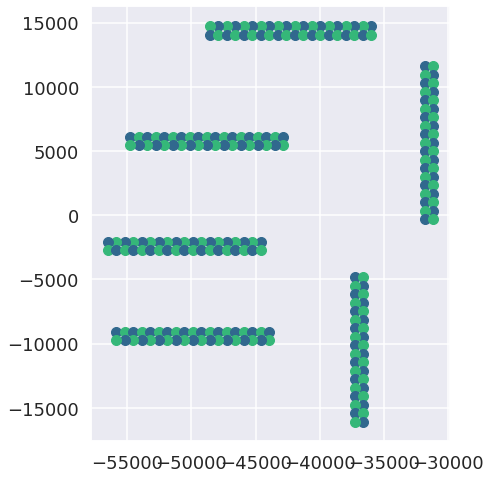

In [11]:
label_vec = [xx['Label'] for xx in summ_dict['InitialPositionList']]
xy_vec = [xx['DeviceCoordinatesUm']['XYStage'] for xx in summ_dict['InitialPositionList']]
label_xy_dict = dict(zip(label_vec, xy_vec))
pos_file_df = files_df.groupby('pos').agg(np.min)
# Cor_pos_df is corrected position DF. In this notebook, correcting the position is not
# necessary as there are only two imaging positions per pad. DF also includes inducer info
# 0, 1, 2 for inducers blank, C, R; respectively
columns = ['x','y','label','pad', 'dist']
n_cols = len(columns)
cor_pos_df = pd.DataFrame(np.empty((n_pos,n_cols)), columns=columns, index=np.arange(n_pos))
for pos in np.arange(n_pos):
    label = pos_file_df.loc[pos,'fn'].split('/')[2]
    x, y = label_xy_dict[label]
    pad = pos_df.loc[pos,'pad']
    cor_pos_df.loc[pos,['x', 'y', 'label', 'pad']] = [x, y, label, pad]
#     files_df.loc[files_df.pos==p_i,'x'] = x
#     files_df.loc[files_df.pos==p_i,'y'] = y

# cor_pos_df.sort_values(by=['pad','padpos'], inplace=True)
    
for p_i in np.arange(n_pos):
    pad = cor_pos_df.loc[p_i,['pad']].values[0]
    pad_xy = cor_pos_df.loc[(cor_pos_df.pad==pad),['x','y']].iloc[0,:].values
    pos_xy = cor_pos_df.loc[p_i,['x','y']].values
    dist = np.sqrt(np.power(pad_xy - pos_xy,2).sum())
    cor_pos_df.loc[p_i, 'dist'] = dist
    
def dist_f(pad_ind):
    '''
    Calculates distance between colonies for input pad index
    '''
    pos_arr = cor_pos_df.loc[cor_pos_df.pad == 3, ['x', 'y']].values
    dist = np.sqrt(np.sum(np.power(np.diff(pos_arr, axis=0),2)))
    return dist
    
plt.figure(figsize=(8,8))
for p_i in np.arange(n_pos):
    colors = sns.color_palette('viridis', n_colors=2)
    point_color = colors[np.int(np.mod(cor_pos_df.loc[p_i,"pad"],2))]
    plt.plot(np.float(cor_pos_df.x[p_i]), 
             -np.float(cor_pos_df.y[p_i]), 
             '.', 
             label=cor_pos_df.label[p_i],
             ms=20,
             c=colors[np.mod(p_i,2)])
plt.gca().set_aspect('equal')
plt.show()
# plt.legend()

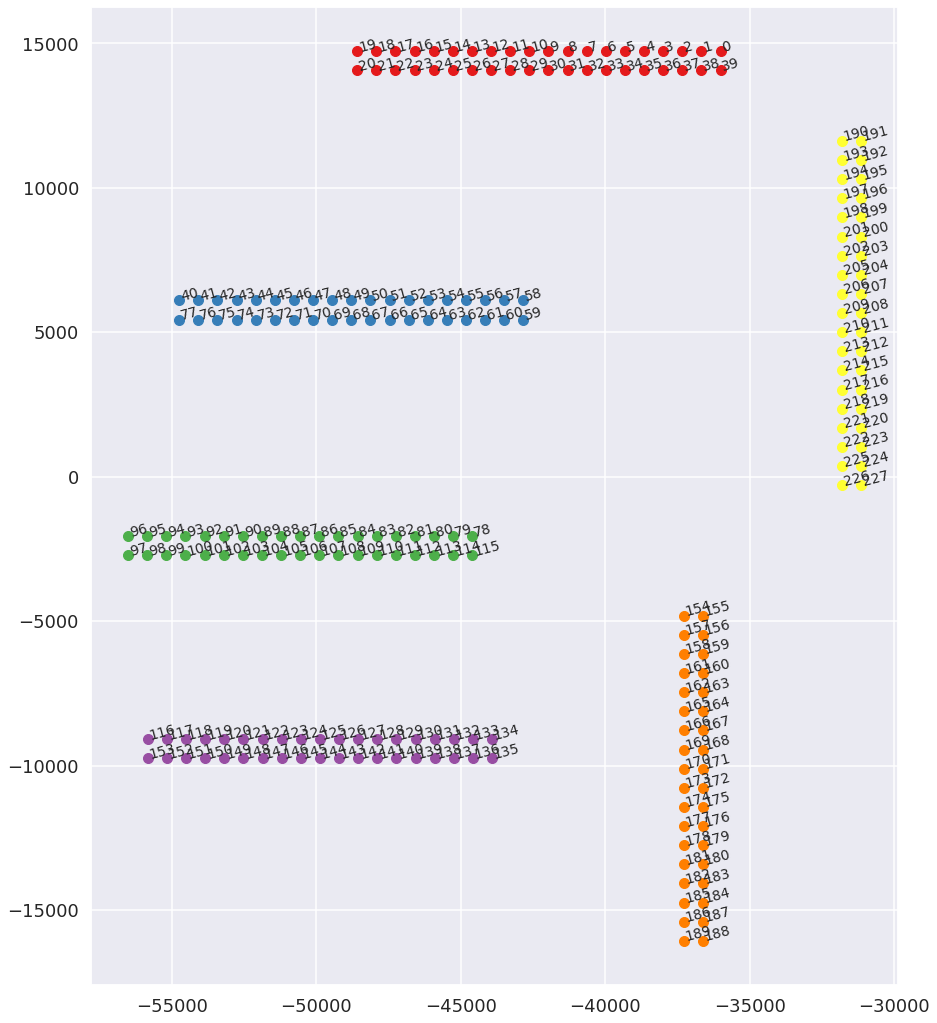

In [12]:
# n_pads=5
plt.figure(figsize=(18,18))
for p_i in np.arange(n_pos):
    colors = sns.color_palette('Set1', n_colors=n_pads)
    point_color = colors[np.int(cor_pos_df.loc[p_i,"pad"])]
    plt.plot(np.float(cor_pos_df.x[p_i]), 
             -np.float(cor_pos_df.y[p_i]), 
             '.', 
             label=cor_pos_df.pad[p_i],
             ms=20,
             c=point_color)
    plt.text(np.float(cor_pos_df.x[p_i]), 
             -np.float(cor_pos_df.y[p_i]), 
#              '{}'.format(np.int(cor_pos_df.padpos[p_i])),
#              '{}'.format(pos_file_df.loc[p_i,'fn'].split('/')[2]),
             '{}'.format(p_i),
             fontsize=14,
             rotation=15)

plt.gca().set_aspect('equal')

In [13]:
files_df.head()

,pos,pad,padcol,padrow,frame,channel,fn,time,padpos
0,0,0,19,1,0,2,../img_1/1-Pos_019_001/img_000000000_2_000.tif,0.0,120.0
1,0,0,19,1,0,3,../img_1/1-Pos_019_001/img_000000000_3_000.tif,2.0,120.0
2,0,0,19,1,0,5,../img_1/1-Pos_019_001/img_000000000_5_000.tif,5.0,120.0
3,1,0,18,1,0,2,../img_1/1-Pos_018_001/img_000000000_2_000.tif,8.0,117.0
4,1,0,18,1,0,3,../img_1/1-Pos_018_001/img_000000000_3_000.tif,10.0,117.0


In [268]:
fn_list = ['200213_pad{}.tif'.format(xx) for xx in np.arange(6)]
sr_boundaries = [1110, 530, 920, 910, 800, 630]
pad_beginnings = [350, 200, 200, 200, 0, 100]
pad_endings = [1000, 200, 200, 1200, 1000, 100]
tup_list = [(10,40),(10,40),(10,40),(10,40),(10,40),(10,40)]#,(40,10),(40,10)]
vert_list = [False, False, False, False, True, True]
flip_list = [False, False, False, True, False, False]
lists = [fn_list, pad_beginnings, pad_endings, sr_boundaries, tup_list, vert_list, flip_list]
pad_boundary=0
class  AnalyzePad():
    def __init__(self, pad_ind):
        self.fn, self.pad_begin, self.pad_end, self.sr_boundary, self.scale_tup, self.vert, self.flip = [xx[pad_ind] for xx in lists]

    def dwn_frames(self):
        chan_regions = [self.sender_region, self.receiver_region, self.receiver_region]
        for i, frame_i in enumerate(self.frame_vec):
            for chan_i in [0,1,2]:
                frame = self.get_frame(frame_i, chan_i)
                thresh = skimage.filters.threshold_li(frame[:,chan_regions[chan_i]])
                thresh = np.max([40,thresh])
                im_occ = frame > thresh
                self.dwn_arr[i, chan_i, :, :] = skimage.transform.downscale_local_mean(frame, self.scale_tup)
                self.dwn_prf[i, chan_i, :, :] = skimage.transform.downscale_local_mean(im_occ, self.scale_tup)
    
    def get_frame(self, frame_ind, chan_ind):
        # grab single frame from tiff file and reshape as necessary
        with skimage.external.tifffile.TiffFile(self.fn) as im:
            img = im.asarray(memmap=True)[np.int(frame_ind*3 + chan_ind),:,:].copy()
            if self.vert:
                img = img.T
            elif self.flip:
                img = img[:,::-1]
        return img

    def make_dwnsmpl(self, frame_vec):
        # Read initial img and make empty dwn array
        self.frame_vec = frame_vec
        img0 = self.get_frame(frame_vec[0],0)
        h, w = img0.shape
        self.sender_region = np.arange(self.pad_begin, self.sr_boundary)
        self.receiver_region = np.arange(self.sr_boundary, w-self.pad_end)
        sh, sw = np.ceil(np.array((h, w)) / np.array(self.scale_tup)).astype(np.int)
        n_frames = len(frame_vec)
        self.dwn_arr = np.zeros((n_frames, 3, sh, sw))
        self.dwn_prf = np.zeros((n_frames, 3, sh, sw))
        self.dwn_frames()
        self.scaled_w, self.scaled_h = sw, sh
        self.w, self.h = w, h

frame_vec = np.arange(0,25)
pads = [AnalyzePad(xx) for xx in np.arange(6)]
_ = [pad.make_dwnsmpl(frame_vec) for pad in pads]


/home/jmp/anaconda3/lib/python3.7/site-packages/skimage/util/shape.py:93: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "


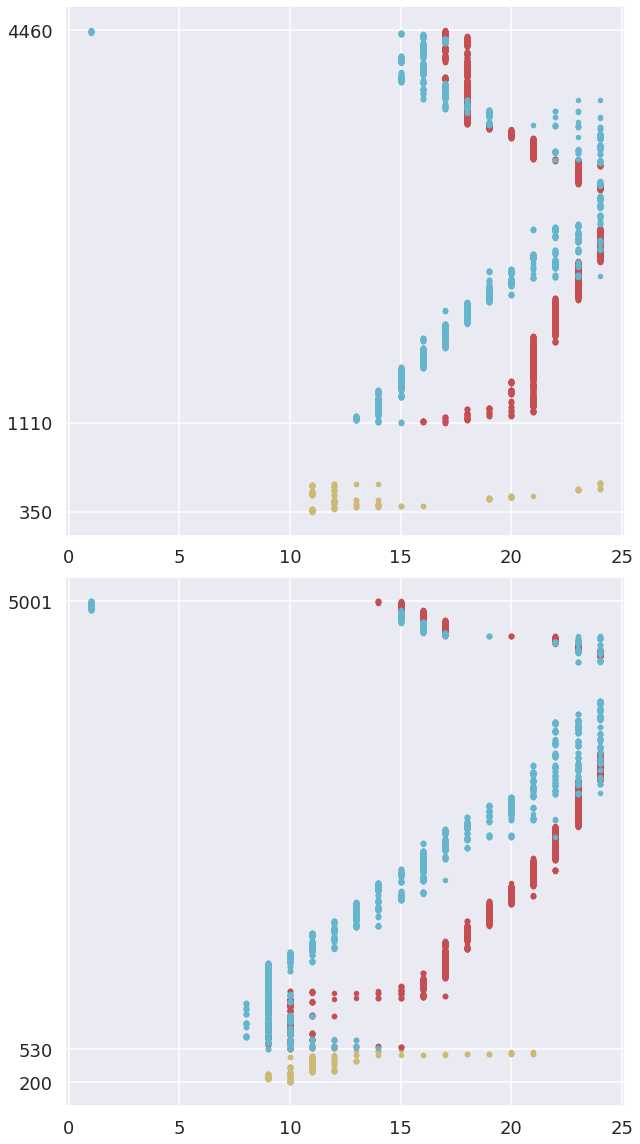

In [270]:
# Try your column-by-column threshold crossing approach
fig, axs = plt.subplots(2, 1, figsize=(9,16))
pad_list = [pads[xx] for xx in [0,1,2,3,4,5]]
colors=['y','r','c']
for pad_i in np.arange(2):
    pad = pad_list[pad_i]
    sr_boundary, pad_begin, pad_end = pad.sr_boundary, pad.pad_begin, pad.w - pad.pad_end
    sender_region = np.arange(pad_begin, sr_boundary)
    receiver_region = np.arange(sr_boundary, pad_end)
    n_frames = len(pad.frame_vec)
    frame0 = pad.frame_vec[0]
    chan_regions = [sender_region, receiver_region, receiver_region]
    for chan_i in [0,1,2]:
        w = len(chan_regions[chan_i])
        summed_arr = np.zeros((n_frames, w))
        for frame_i in pad.frame_vec:
            img = pad.get_frame(frame_i, chan_i)[:,chan_regions[chan_i]]
            summed_arr[frame_i-frame0,:] = img.sum(axis=0)
        frame_arr = np.tile(pad.frame_vec.reshape(n_frames,1),(1,w))
        pos_arr = np.tile(np.arange(w).reshape(1,w)+chan_regions[chan_i][0],(n_frames,1))
        thresh = skimage.filters.threshold_li(summed_arr)
        bool_arr = summed_arr > thresh
        thresh_frames = (bool_arr*frame_arr).flatten()
        thresh_pos = (bool_arr*pos_arr).flatten()
        cross_df = pd.DataFrame(dict(zip(['frame','pos'],[thresh_frames,thresh_pos])))
        cross_df.drop(cross_df.index[cross_df.frame==0],inplace=True,axis=0)
        cross_df = cross_df.groupby('pos').agg(np.min).reset_index()
        cross_frame, cross_pos = cross_df.loc[:,['frame','pos']].values.T
#         axs[pad_i,chan_i-1].imshow(summed_arr,aspect=200) 
        axs[pad_i].plot(cross_frame, cross_pos,'.',color=colors[chan_i])
    axs[pad_i].set_yticks([pad_begin, sr_boundary, pad_end])
#         print(cross_df)
#         axs[pad_i, chan_i].plot(x_arr.T, avg_fluor.T,'.')#,vmin=1e2,vmax=7e3,aspect=8)
fig.tight_layout()

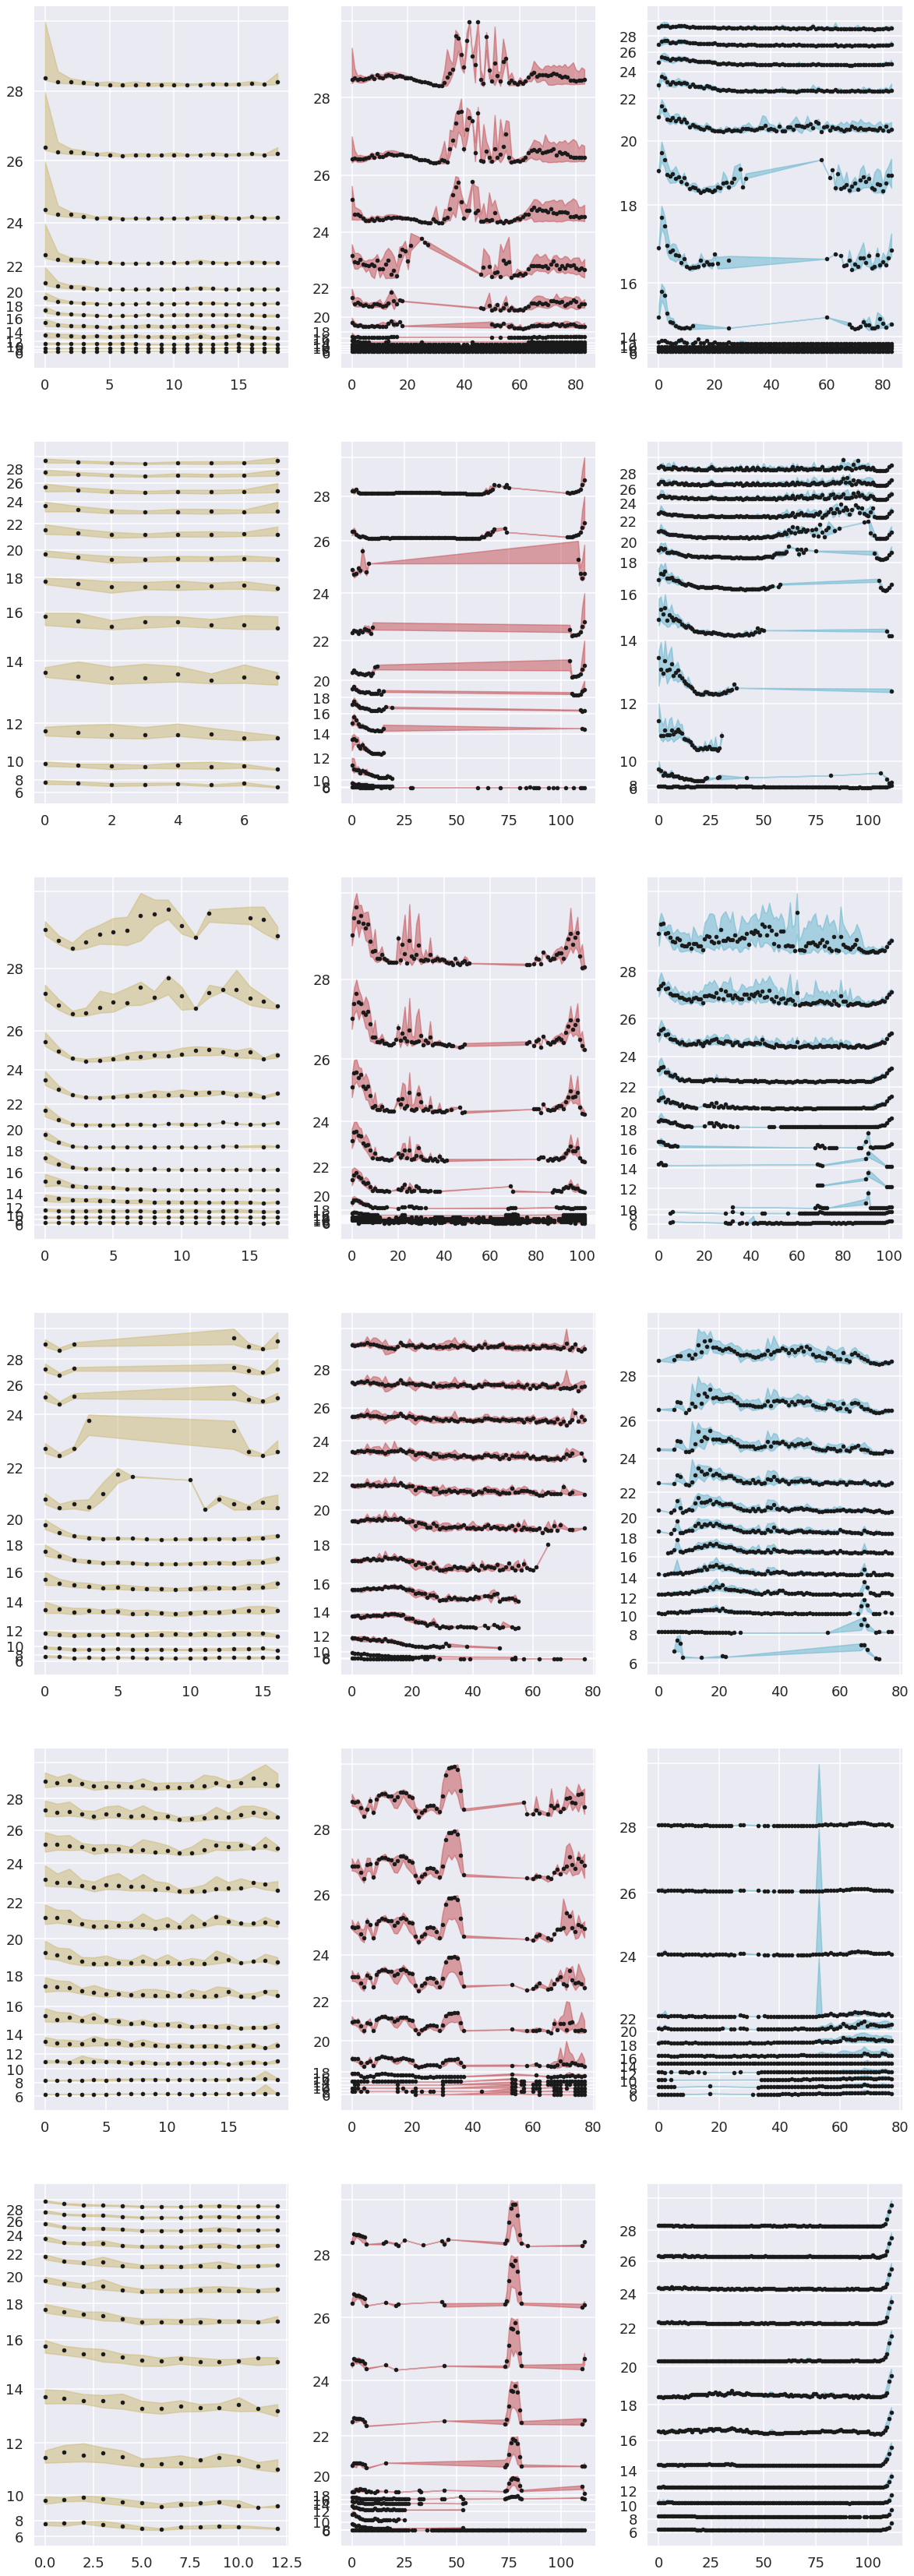

In [229]:
fig, axs = plt.subplots(6, 3, figsize=(20,60))
pad_list = [pads[xx] for xx in [0,1,2,3,4,5]]
colors=['y','r','c']
for pad_i in np.arange(6):
    pad = pad_list[pad_i]
    sr_boundary = np.int(pad.sr_boundary / pad.scale_tup[1])
    pad_begin = np.int(pad.pad_begin / pad.scale_tup[1])
    pad_end = np.int((pad.w - pad.pad_end) / pad.scale_tup[1])
    dwn_arr = pad.dwn_arr.copy()
    prf_arr = pad.dwn_prf.copy()
    dwn_arr[np.isnan(dwn_arr)] = 0
    for chan_i in [0,1,2]:
        dwn_frame = dwn_arr[:,chan_i,:,:]
        prf_frame = prf_arr[:,chan_i,:,:]
        if chan_i == 0:
            dwn_frame = dwn_frame[:,:,pad_begin:sr_boundary]
            prf_frame = prf_frame[:,:,pad_begin:sr_boundary]
        else:
            dwn_frame = dwn_frame[:,:,sr_boundary:pad_end]
            prf_frame = prf_frame[:,:,sr_boundary:pad_end]
        im_mask = prf_frame > 0.1
        prf_frame[False==im_mask] = np.inf
        avg_fluor = (dwn_frame*im_mask)/prf_frame
        n_frames, im_h, im_w = dwn_frame.shape
        x_arr = np.tile(np.arange(im_w).reshape((1, im_w)), (im_h,1))
        frame_max = 0
        yticks = [frame_max]
        for frame_i in pad.frame_vec[::2]-pad.frame_vec.min():
            frame_avg_fluor = avg_fluor[frame_i,:,:]
            frame_im_mask = im_mask[frame_i,:,:]
            frame_prf = prf_frame[frame_i,:,:]
            frame_avg_fluor[np.isnan(frame_avg_fluor)] = 0
#             t_arr = np.tile(pad.frame_vec.reshape((n_frames,1)), (1,im_w))
            columns = ['fluor','occ','mask','pos']
            data = [frame_avg_fluor.flatten(),frame_prf.flatten(),frame_im_mask.flatten(),x_arr.flatten()]
            df = pd.DataFrame(dict(zip(columns, data)))
            df.drop(df.index[df.fluor==0],inplace=True,axis=0)
            df.sort_values(by='fluor', inplace=True)
            gb_x = df.groupby('pos')
            x_vec = np.arange(im_w)
            top_vec = np.zeros(im_w)
            bot_vec = np.zeros(im_w)
            med_vec = np.zeros(im_w)
            for xx in x_vec:
                if xx in gb_x.groups.keys():
                    sub_df = gb_x.get_group(xx)
                    n = sub_df.shape[0]
                    if n < 4:
                        top_vec[xx] = sub_df.fluor.values.max()
                        med_vec[xx] = sub_df.fluor.values.mean()
                        bot_vec[xx] = sub_df.fluor.values.min()
                    else:
                        top_vec[xx] = sub_df.fluor.values[np.int(0.75*n)]
                        med_vec[xx] = sub_df.fluor.values[np.int(n/2)]
                        bot_vec[xx] = sub_df.fluor.values[np.int(0.25*n)]
            keep_bool = top_vec > 0
            x_vec = x_vec[keep_bool]
            top_vec = top_vec[keep_bool] + frame_max
            med_vec = med_vec[keep_bool] + frame_max
            bot_vec = bot_vec[keep_bool] + frame_max
            axs[pad_i,chan_i].fill_between(x_vec, top_vec, bot_vec, alpha=0.5,color=colors[chan_i])
            axs[pad_i,chan_i].plot(x_vec, med_vec,'.k')
            frame_max = np.max(top_vec)+100
            yticks.append(frame_max)
        axs[pad_i,chan_i].set_yticks(yticks)
        axs[pad_i,chan_i].set_yticklabels(pad.frame_vec[::2])
#         axs[pad_i, chan_i].plot(x_arr.T, avg_fluor.T,'.')#,vmin=1e2,vmax=7e3,aspect=8)

/home/jmp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


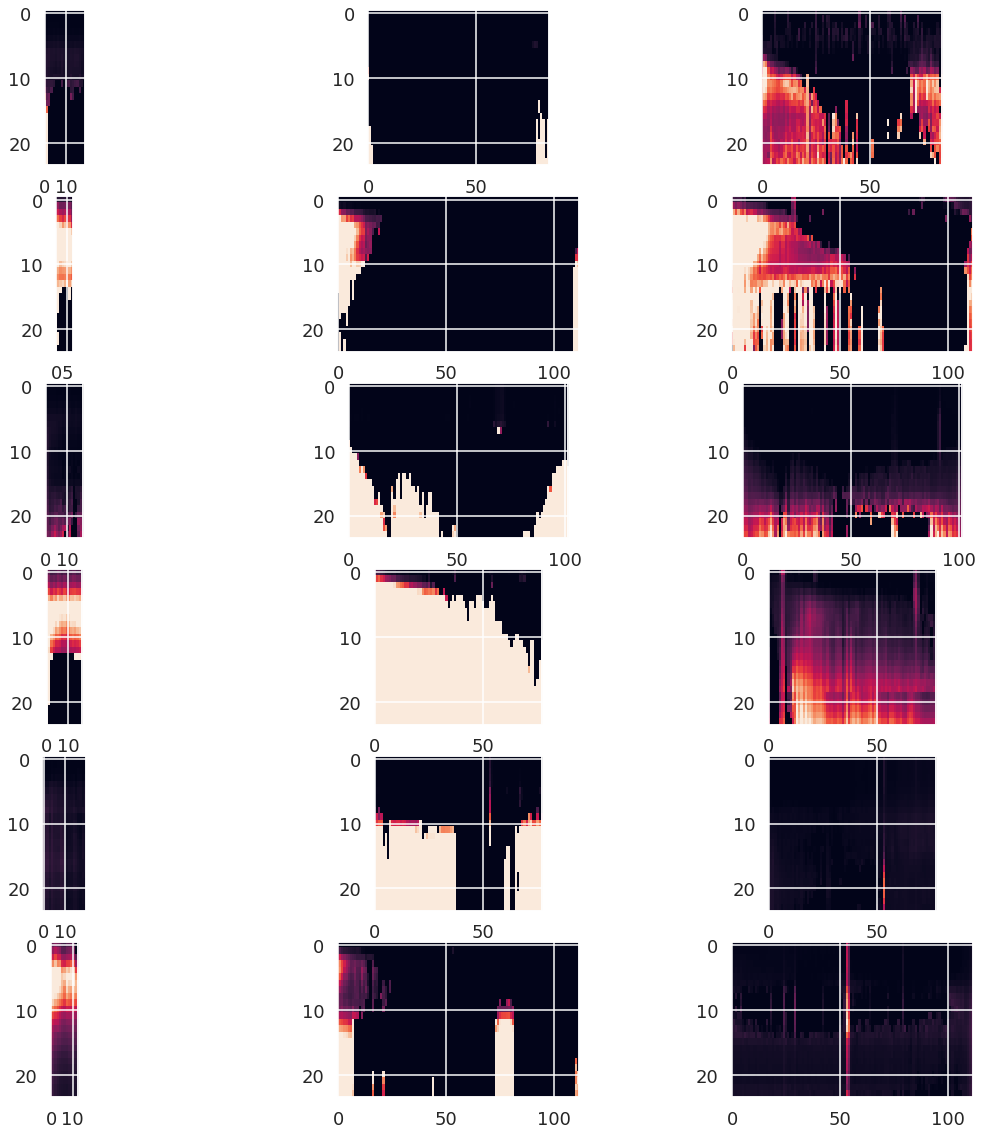

In [194]:
fig, axs = plt.subplots(6, 3, figsize=(20,20))
pad_list = [pads[xx] for xx in [0,1,2,3,4,5]]

for pad_i in np.arange(6):
    pad = pad_list[pad_i]
    sr_boundary = np.int(pad.sr_boundary / pad.scale_tup[1])
    pad_begin = np.int(pad.pad_begin / pad.scale_tup[1])
    pad_end = np.int((pad.w - pad.pad_end) / pad.scale_tup[1])
    dwn_arr = pad.dwn_arr.copy()
    prf_arr = pad.dwn_prf.copy()
    dwn_arr[np.isnan(dwn_arr)] = 0
    for chan_i in [0,1,2]:
        dwn_frame = dwn_arr[:,chan_i,:,:]
        prf_frame = prf_arr[:,chan_i,:,:]
        if chan_i == 0:
            dwn_frame = dwn_frame[:,:,pad_begin:sr_boundary]
            prf_frame = prf_frame[:,:,pad_begin:sr_boundary]
        else:
            dwn_frame = dwn_frame[:,:,sr_boundary:pad_end]
            prf_frame = prf_frame[:,:,sr_boundary:pad_end]
        n_frames, im_h, im_w = dwn_frame.shape
        im_mask = prf_frame > 0.1
        avg_fluor = (dwn_frame*im_mask).sum(axis=1)/prf_frame.sum(axis=1)
        avg_fluor[np.isnan(avg_fluor)] = 0
        t_arr = np.tile(pad.frame_vec.reshape((n_frames,1)), (1,im_w))
        x_arr = np.tile(np.arange(im_w).reshape((1, im_w)), (n_frames,1))
        axs[pad_i, chan_i].imshow(avg_fluor,vmin=1e2,vmax=7e3,aspect=3)

/home/jmp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


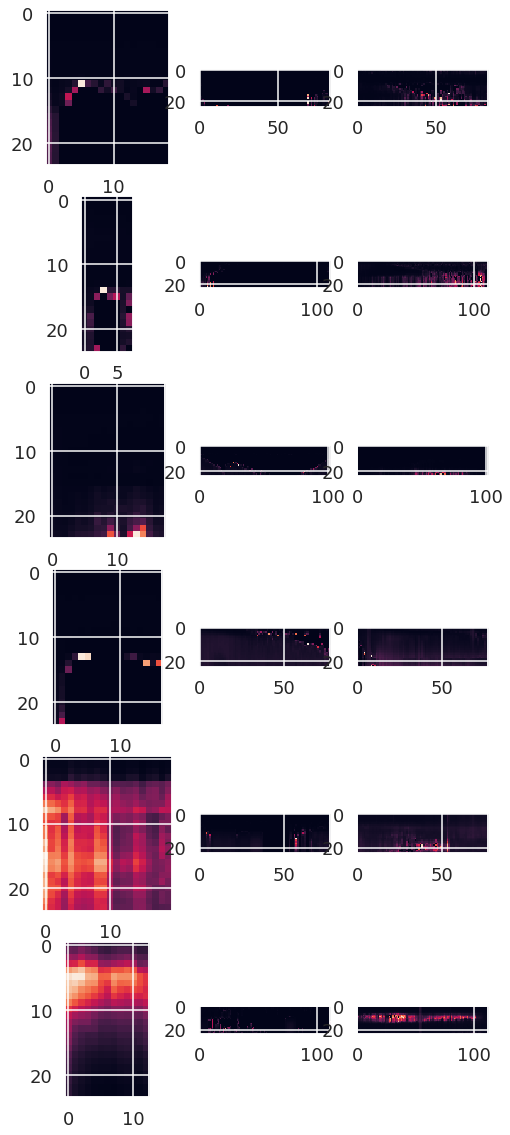

In [122]:
fig, axs = plt.subplots(6, 3, figsize=(8,20))
pad_list = [pads[xx] for xx in [0,1,2,3,4,5]]

for pad_i in np.arange(6):
    pad = pad_list[pad_i]
    sr_boundary = np.int(pad.sr_boundary / pad.scale_tup[1])
    pad_begin = np.int(pad.pad_begin / pad.scale_tup[1])
    pad_end = np.int((pad.w - pad.pad_end) / pad.scale_tup[1])
    dwn_arr = pad.dwn_arr.copy()
    prf_arr = pad.dwn_prf.copy()
    dwn_arr[np.isnan(dwn_arr)] = 0
    for chan_i in [0,1,2]:
        dwn_frame = dwn_arr[:,chan_i,:,:]
        prf_frame = prf_arr[:,chan_i,:,:]
        if chan_i == 0:
            dwn_frame = dwn_frame[:,:,pad_begin:sr_boundary]
            prf_frame = prf_frame[:,:,pad_begin:sr_boundary]
        else:
            dwn_frame = dwn_frame[:,:,sr_boundary:pad_end]
            prf_frame = prf_frame[:,:,sr_boundary:pad_end]
        im_mask = prf_frame>0
        avg_fluor = (dwn_frame*im_mask).sum(axis=1)/prf_frame.sum(axis=1)
        avg_fluor[np.isnan(avg_fluor)] = 0
        axs[pad_i, chan_i].imshow(avg_fluor)#,vmin=0,vmax=8e3,aspect=4)

In [ ]:
import matplotlib.animation as anm
from IPython.display import HTML

def write_movie(scale=4, pad_ind=3, skip=5):
    n_frames = files_df.frame.max()+1
    h, w = im_height//scale, im_width//scale
    plt.close('all')
    pixels_per_um = 1/(1.6*1.6*scale)
    pad_df = cor_pos_df.loc[cor_pos_df.pad==pad_ind,:]
    pos_list = np.unique(pad_df.index.values)
    xlims = np.array([pad_df.x.min(), pad_df.x.max()+1400])*pixels_per_um
    ylims = np.array([pad_df.y.min(), pad_df.y.max()+1400])*pixels_per_um
    rel_mins = np.concatenate([[xlims], [ylims]],axis=0).astype(np.int)
    pad_h = np.int(np.ceil(np.diff(ylims)))
    pad_w = np.int(np.ceil(np.diff(xlims)))
    fig_h, fig_w = np.array([pad_h, pad_w])/(100/scale)
    pad_arr = np.zeros((pad_h, pad_w, 3))
    img_arr = np.zeros((pad_h, pad_w, 3))
#     yfp_norm = mpl_colors.Normalize(2e2, 1e4,clip=True)
#     rfp_norm = mpl_colors.Normalize(1e4, 3e4,clip=True)
#     cfp_norm = mpl_colors.Normalize(1e4, 3e4,clip=True)
    yfp_norm = mpl_colors.Normalize(100, 5e3,clip=True)
    rfp_norm = mpl_colors.Normalize(100, 1e4,clip=True)
    cfp_norm = mpl_colors.Normalize(100, 1e4,clip=True)
    chan_vec = [2,3,5]
    norm_vec = [yfp_norm, rfp_norm, cfp_norm]
    
    pos_lims = (pad_df[['x','y']]*pixels_per_um).astype(np.int)

    count_arr = np.zeros((pad_h, pad_w))
    for pos in pos_list:
        x0, y0 = (pos_lims.loc[pos,:].values - rel_mins[:,0]).astype(np.int)
        count_arr[y0:y0+h,x0:x0+w] += 1
    count_arr[count_arr<=0] = 1

    def load_img(frame, pos, channel, rotation=180, scale=scale, sigma=3):
        fn = files_df.loc[(files_df.frame==frame)&(files_df.pos==pos)&(files_df.channel==channel),'fn'].values[0]
        img = skimage.filters.gaussian(skimage.io.imread(fn).astype(np.float), sigma)
        img = skimage.transform.downscale_local_mean(img, (scale, scale))
        return skimage.transform.rotate(img, rotation)

    def get_frame_arr(frame_ind):
        bg_arr = np.zeros((h,w))
        im_arr = np.zeros((h,w))
        # get background image
        bg_pos_list = [200,202,203,204,205]
        n_bg = len(bg_pos_list)
        for chan_i, channel in enumerate(chan_vec):
            bg_arr[:] = 0
            bg_arr += np.mean([load_img(frame_ind, pos, channel) for pos in bg_pos_list], axis=0)
            for pos in pos_list:
                x0, y0 = (pos_lims.loc[pos,:].values - rel_mins[:,0]).astype(np.int)
                im_arr[:] = 0
                im_arr += load_img(frame_ind, pos, channel)
                pad_arr[y0:y0+h,x0:x0+w,chan_i] += im_arr - bg_arr
            pad_arr[:,:,chan_i] /= count_arr

    fig, ax = plt.subplots(1, 1, figsize=(fig_w,fig_h+1.2))
    im = ax.imshow(pad_arr, animated=True, interpolation='none')
    #     cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Pad {}".format(pad_ind))

    fig.tight_layout()

    def animate(i):
        pad_arr[:] = 0
        get_frame_arr(i)
        img_arr[:,:,0] = rfp_norm(pad_arr[:,:,1]) + 0.75*yfp_norm(pad_arr[:,:,0])
        img_arr[:,:,1] = 0.75*yfp_norm(pad_arr[:,:,0]) + 0.75*cfp_norm(pad_arr[:,:,2])
        img_arr[:,:,2] = 0.75*cfp_norm(pad_arr[:,:,2])
        im.set_array(img_arr)

    anim = anm.FuncAnimation(fig, animate, interval=100, frames=np.arange(0,n_frames,skip))


    plt.close('all')
    return anim
    #HTML(anim.to_html5_video())    

for pad_ind in np.arange(n_pads):
    anim = write_movie(scale=8, pad_ind=pad_ind,skip=2)
    anim.save('200213_pad{}.gif'.format(pad_ind), dpi=80, fps=5, writer='pillow')


In [ ]:
for chan in [2,3,5]:
    plt.figure()
    img = get_frame(18, 21, chan)
    _ = plt.hist(img.flatten(),bins=20)
    plt.title(chan)
    thresh = skimage.filters.threshold_li(img)
    plt.figure()
    plt.imshow(img,vmin=thresh,vmax=2*thresh)
    print(thresh)

In [ ]:
import matplotlib.animation as anm
from IPython.display import HTML

def write_tiff(fn_out, scale=4, pad_ind=3, skip=5):
    n_frames = files_df.frame.max()+1
    h, w = im_height//scale, im_width//scale
    plt.close('all')
    pixels_per_um = 1/(1.6*1.6*scale)
    pad_df = cor_pos_df.loc[cor_pos_df.pad==pad_ind,:]
    pos_list = np.unique(pad_df.index.values)
    xlims = np.array([pad_df.x.min(), pad_df.x.max()+1400])*pixels_per_um
    ylims = np.array([pad_df.y.min(), pad_df.y.max()+1400])*pixels_per_um
    rel_mins = np.concatenate([[xlims], [ylims]],axis=0).astype(np.int)
    pad_h = np.int(np.ceil(np.diff(ylims)))
    pad_w = np.int(np.ceil(np.diff(xlims)))
    pad_arr = np.zeros((pad_h, pad_w, 3))
#     yfp_norm = mpl_colors.Normalize(2e2, 1e4,clip=True)
#     rfp_norm = mpl_colors.Normalize(1e4, 3e4,clip=True)
#     cfp_norm = mpl_colors.Normalize(1e4, 3e4,clip=True)
    yfp_norm = mpl_colors.Normalize(100, 5e3,clip=True)
    rfp_norm = mpl_colors.Normalize(100, 1e4,clip=True)
    cfp_norm = mpl_colors.Normalize(100, 1e4,clip=True)
    chan_vec = [2,3,5]
    norm_vec = [yfp_norm, rfp_norm, cfp_norm]
    
    pos_lims = (pad_df[['x','y']]*pixels_per_um).astype(np.int)

    count_arr = np.zeros((pad_h, pad_w))
    for pos in pos_list:
        x0, y0 = (pos_lims.loc[pos,:].values - rel_mins[:,0]).astype(np.int)
        count_arr[y0:y0+h,x0:x0+w] += 1
    count_arr[count_arr<=0] = 1

    def load_img(frame, pos, channel, rotation=180, scale=scale, sigma=3):
        fn = files_df.loc[(files_df.frame==frame)&(files_df.pos==pos)&(files_df.channel==channel),'fn'].values[0]
#         img = skimage.filters.gaussian(skimage.io.imread(fn).astype(np.float), sigma)
        img = skimage.io.imread(fn).astype(np.float)
        img = skimage.transform.downscale_local_mean(img, (scale, scale))
        return skimage.transform.rotate(img, rotation)

    def get_frame_arr(frame_ind):
        bg_arr = np.zeros((h,w))
        im_arr = np.zeros((h,w))
        # get background image
        bg_pos_list = [200,202,203,204,205]
        n_bg = len(bg_pos_list)
        for chan_i, channel in enumerate(chan_vec):
            bg_arr[:] = 0
            bg_arr += np.mean([load_img(frame_ind, pos, channel) for pos in bg_pos_list], axis=0)
            for pos in pos_list:
                x0, y0 = (pos_lims.loc[pos,:].values - rel_mins[:,0]).astype(np.int)
                im_arr[:] = 0
                im_arr += load_img(frame_ind, pos, channel)
                pad_arr[y0:y0+h,x0:x0+w,chan_i] += im_arr - bg_arr
            pad_arr[:,:,chan_i] /= count_arr
            pad_arr[pad_arr<0] = 0

    def animate(i):
        pad_arr[:] = 0
        get_frame_arr(i)
        return pad_arr

    with TiffWriter(fn_out, bigtiff=True, imagej=True) as tif:
        for i in np.arange(0,n_frames,skip):#n_frames):
            pad_arr = animate(i)
            for j in np.arange(3):
                tif.save((pad_arr[:,:,j]).astype(np.uint16).reshape((1,pad_h, pad_w)))

    plt.close('all')
    return anim
    #HTML(anim.to_html5_video())    

for pad_ind in np.arange(n_pads):
    fn_out = '200213_pad{}.tif'.format(pad_ind)
    write_tiff(fn_out, scale=1, pad_ind=pad_ind,skip=1)


In [ ]:
fn_list = ['200213_pad{}.tif'.format(xx) for xx in np.arange(6)]
fig, axs = plt.subplots(6,3,figsize=(10,20))
for ax_i, fn in enumerate(fn_list):
    with skimage.external.tifffile.TiffFile(fn) as im:
        im_arr = im.asarray(memmap=True)
        yfp_arr, rfp_arr, cfp_arr = [im_arr[i::3,:,:] for i in [0,1,2]]
        for ax_j, fp_arr in enumerate([yfp_arr, rfp_arr, cfp_arr]):
            if ax_i in np.arange(4):
                fp_line = fp_arr.sum(axis=1)
            else:
                fp_line = fp_arr.sum(axis=2)
            fp_thresh = skimage.filters.threshold_li(fp_line[:20,500:-500])
            axs[ax_i,ax_j].imshow(fp_line > fp_thresh,aspect=100)
    


In [ ]:
import matplotlib.animation as anm
from IPython.display import HTML

def plot_frame(pad_ind, frame_ind):
    h, w = im_height//scale, im_width//scale
    plt.close('all')
    pixels_per_um = 1/(1.6*1.6*scale)
    pad_df = cor_pos_df.loc[cor_pos_df.pad==pad_ind,:]
    pos_list = np.unique(pad_df.index.values)
    xlims = np.array([pad_df.x.min(), pad_df.x.max()+1400])*pixels_per_um
    ylims = np.array([pad_df.y.min(), pad_df.y.max()+1400])*pixels_per_um
    rel_mins = np.concatenate([[xlims], [ylims]],axis=0).astype(np.int)
    pad_h = np.int(np.ceil(np.diff(ylims)))
    pad_w = np.int(np.ceil(np.diff(xlims)))
    fig_h, fig_w = np.array([pad_h, pad_w])/(100/scale)
    pad_arr = np.zeros((pad_h, pad_w, 3))
    img_arr = np.zeros((pad_h, pad_w, 3))
#     yfp_norm = mpl_colors.Normalize(2e2, 1e4,clip=True)
#     rfp_norm = mpl_colors.Normalize(1e4, 3e4,clip=True)
#     cfp_norm = mpl_colors.Normalize(1e4, 3e4,clip=True)
    yfp_norm = mpl_colors.Normalize(100, 5e3,clip=True)
    rfp_norm = mpl_colors.Normalize(100, 1e4,clip=True)
    cfp_norm = mpl_colors.Normalize(100, 1e4,clip=True)
    chan_vec = [2,3,5]
    norm_vec = [yfp_norm, rfp_norm, cfp_norm]
    
    pos_lims = (pad_df[['x','y']]*pixels_per_um).astype(np.int)

    count_arr = np.zeros((pad_h, pad_w))
    for pos in pos_list:
        x0, y0 = (pos_lims.loc[pos,:].values - rel_mins[:,0]).astype(np.int)
        count_arr[y0:y0+h,x0:x0+w] += 1
    count_arr[count_arr<=0] = 1

    def load_img(pad, frame, channel, rotation=180, scale=scale, sigma=3):
        fn = files_df.loc[(files_df.frame==frame)&(files_df.pos==pos)&(files_df.channel==channel),'fn'].values[0]
        img = skimage.filters.gaussian(skimage.io.imread(fn).astype(np.float), sigma)
        img = skimage.transform.downscale_local_mean(img, (scale, scale))
        return skimage.transform.rotate(img, rotation)

    def get_frame_arr(frame_ind):
        bg_arr = np.zeros((h,w))
        im_arr = np.zeros((h,w))
        # get background image
        bg_pos_list = [200,202,203,204,205]
        n_bg = len(bg_pos_list)
        for chan_i, channel in enumerate(chan_vec):
            bg_arr[:] = 0
            bg_arr += np.mean([load_img(frame_ind, pos, channel) for pos in bg_pos_list], axis=0)
            for pos in pos_list:
                x0, y0 = (pos_lims.loc[pos,:].values - rel_mins[:,0]).astype(np.int)
                im_arr[:] = 0
                im_arr += load_img(frame_ind, pos, channel)
                pad_arr[y0:y0+h,x0:x0+w,chan_i] += im_arr - bg_arr
            pad_arr[:,:,chan_i] /= count_arr

    fig, ax = plt.subplots(1, 1, figsize=(fig_w,fig_h+1.2))
    im = ax.imshow(pad_arr, animated=True, interpolation='none')
    #     cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Pad {}".format(pad_ind))

    fig.tight_layout()

    def animate(i):
        pad_arr[:] = 0
        get_frame_arr(i)
        img_arr[:,:,0] = rfp_norm(pad_arr[:,:,1]) + 0.75*yfp_norm(pad_arr[:,:,0])
        img_arr[:,:,1] = 0.75*yfp_norm(pad_arr[:,:,0]) + 0.75*cfp_norm(pad_arr[:,:,2])
        img_arr[:,:,2] = 0.75*cfp_norm(pad_arr[:,:,2])
        im.set_array(img_arr)

    anim = anm.FuncAnimation(fig, animate, interval=100, frames=np.arange(0,n_frames,skip))


    plt.close('all')
    return anim
    #HTML(anim.to_html5_video())    

for pad_ind in np.arange(n_pads):
    anim = write_movie(scale=8, pad_ind=pad_ind,skip=2)
    anim.save('200213_pad{}.gif'.format(pad_ind), dpi=80, fps=5, writer='pillow')


200213_pad0.tif
200213_pad1.tif
200213_pad2.tif
200213_pad3.tif
200213_pad4.tif
200213_pad5.tif


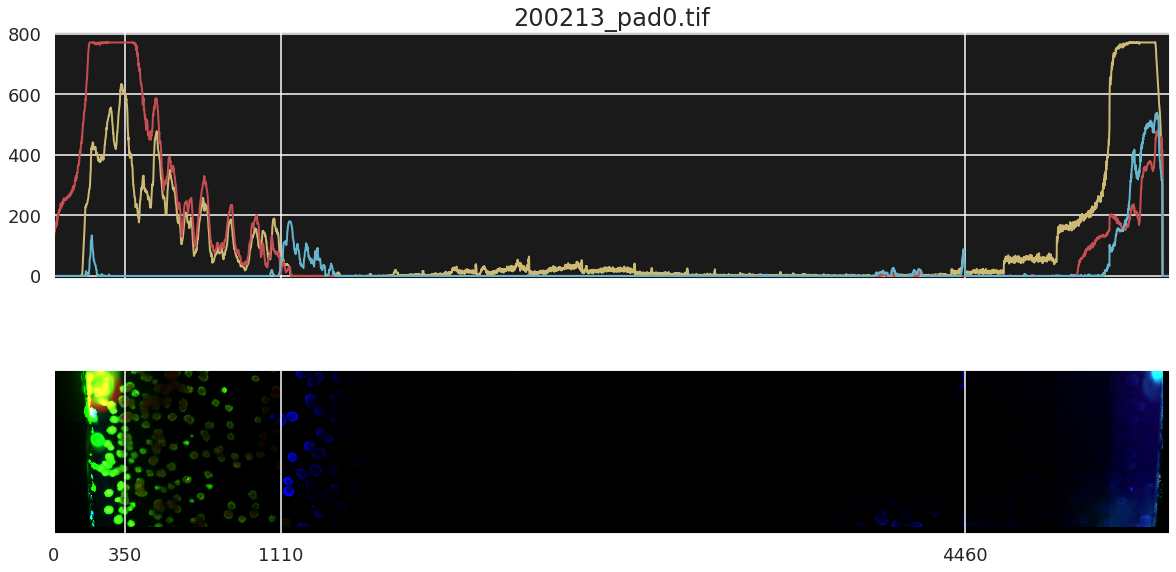

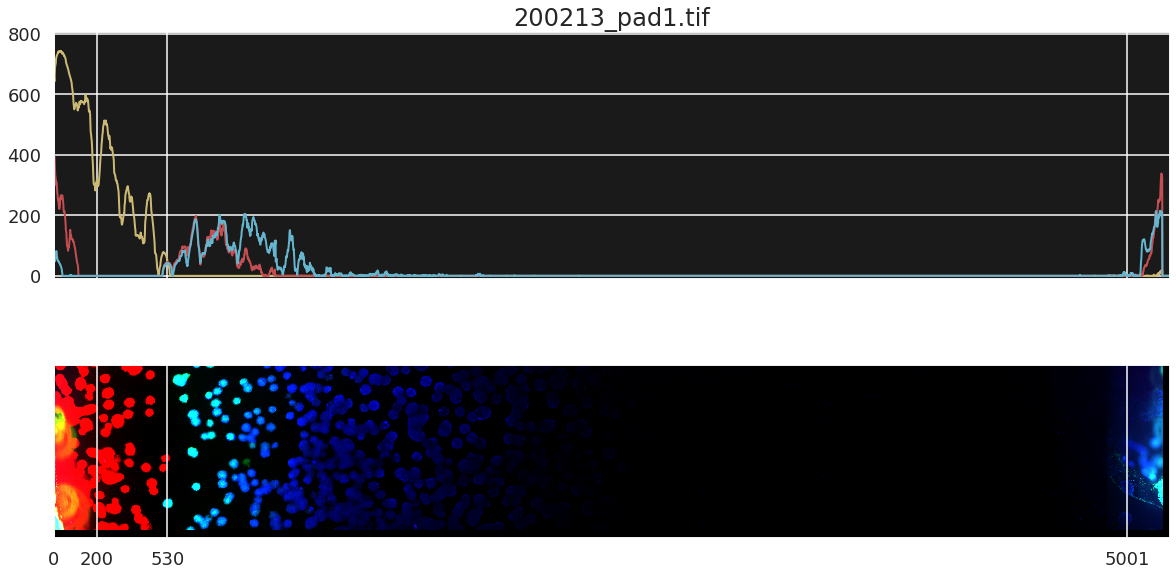

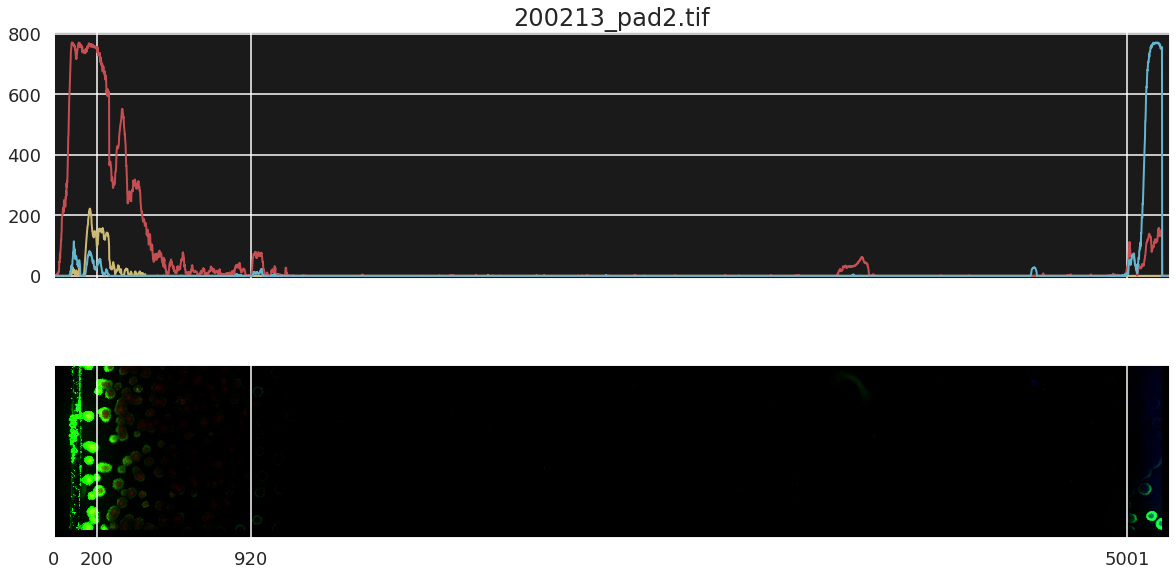

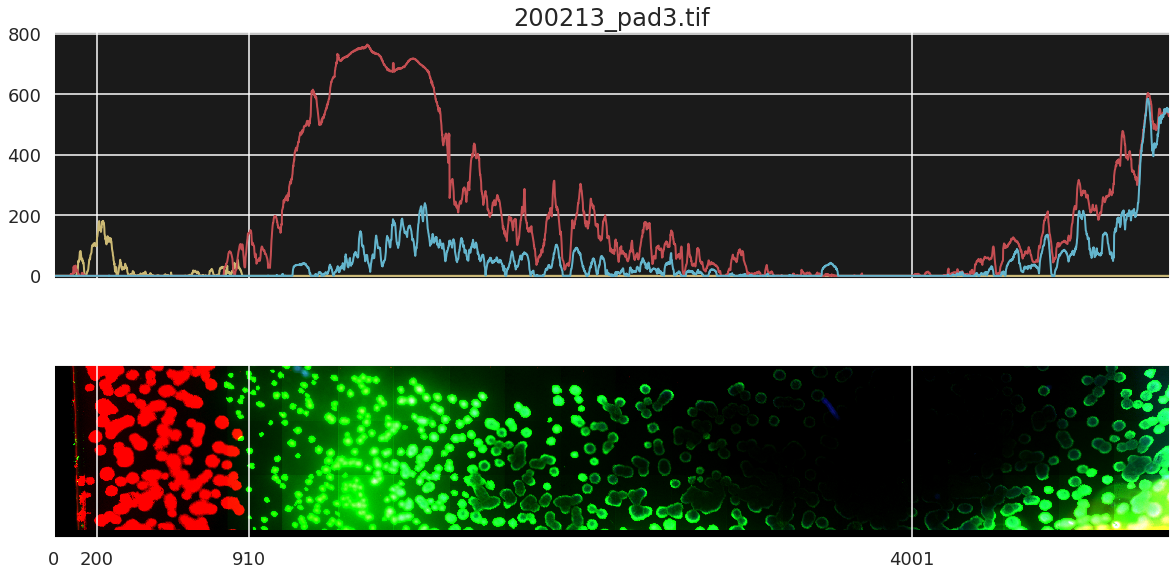

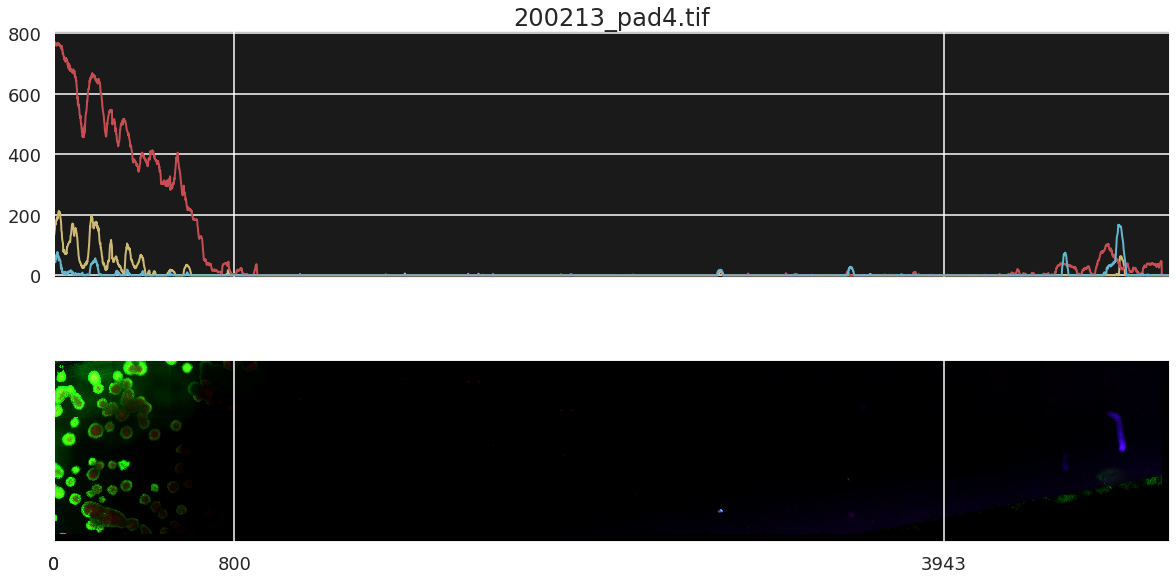

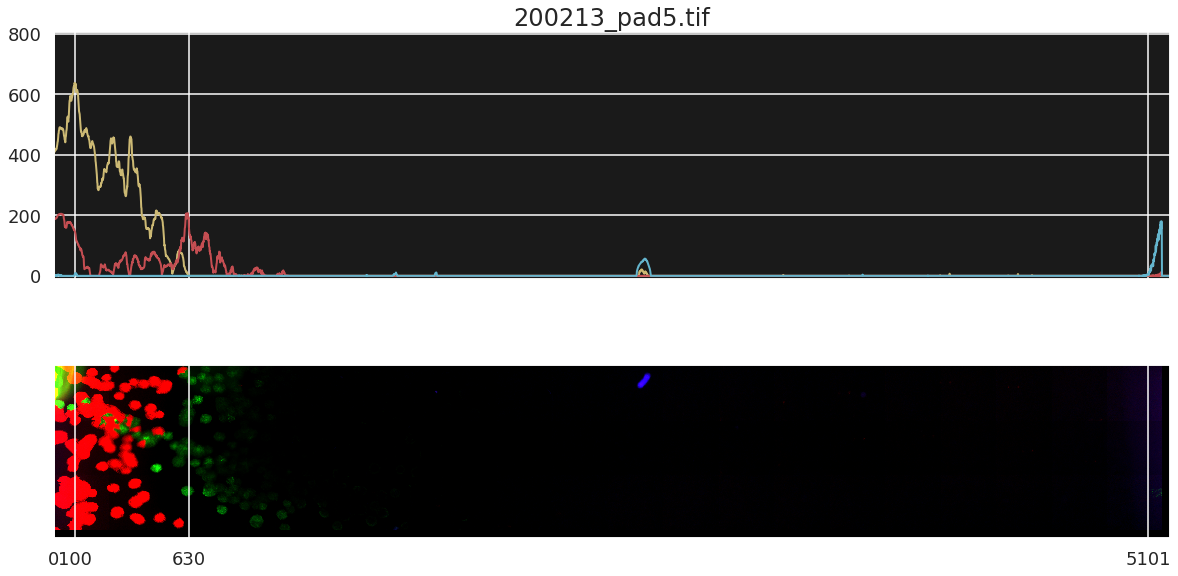

In [105]:
yfp_norm = mpl_colors.Normalize(100, 5e3,clip=True)
rfp_norm = mpl_colors.Normalize(100, 1e4,clip=True)
cfp_norm = mpl_colors.Normalize(100, 1e4,clip=True)
norms = [yfp_norm, rfp_norm, cfp_norm]

# Analyize pad 0
fn = fn_list[0]
frame = 14
def plot_pad_profile(fn, frame, pad_begin, pad_end, sr_boundary, vert=False, flip=False):
    fig, axs = plt.subplots(2,1,figsize=(20,10),sharex=True)
    prof_ax, img_ax = axs
    with skimage.external.tifffile.TiffFile(fn) as im:
        # Get frame and reshape as needed
        im_arr = im.asarray(memmap=True)
#         _, h, w = im_arr.shape
#         im_arr = im_arr.reshape((60,3,h,w))
        frame_slice = slice(frame*3,frame*3+3)
        yfp_frame, rfp_frame, cfp_frame = im_arr[frame_slice,:,:]
        arr_list = [yfp_frame, rfp_frame, cfp_frame]
        if vert:
            for i in [0,1,2]:
                arr_list[i] = arr_list[i].T
        if flip:
            for i in [0,1,2]:
                arr_list[i] = arr_list[i][:,::-1]
        h, w = arr_list[0].shape
        
        # Profile
        sender_region = np.arange(pad_begin,sr_boundary)
        receiver_region = np.arange(sr_boundary, w-pad_end)
        chan_regions = [sender_region, receiver_region, receiver_region]
        profiles = np.zeros((h,w,3))
        threshs = np.zeros(3)
        colors = ['y', 'r', 'c']
        for i, chan_frame in enumerate(arr_list):
            threshs[i] = skimage.filters.threshold_yen(chan_frame[:,chan_regions[i]])
            profiles[:,:,i] = chan_frame > threshs[i]
            prof_ax.plot(profiles[:,:,i].sum(axis=0),colors[i])
        prof_ax.set_xticks([])
        prof_ax.set_xlim([0,w])
        prof_ax.set_ylim([-10,h])
        prof_ax.set_title(fn)
        prof_ax.set_facecolor('k')
        
        # img
        rgb_img = np.concatenate([norm(chan_frame).reshape((h,w,1)) for chan_frame, norm in zip(arr_list, norms)],axis=2)
        img_ax.imshow(rgb_img)
        img_ax.set_xticks([0,pad_begin,sr_boundary,w-pad_end])
        img_ax.set_yticks([])

fn_list = ['200213_pad{}.tif'.format(xx) for xx in np.arange(6)]
sr_boundaries = [1110, 530, 920, 910, 800, 630]
pad_beginnings = [350, 200, 200, 200, 0, 100]
pad_endings = [1000, 200, 200, 1200, 1000, 100]
tup_list = [(10,40),(10,40),(10,40),(10,40),(10,40),(10,40)]#,(40,10),(40,10)]
vert_list = [False, False, False, False, True, True]
flip_list = [False, False, False, True, False, False]
lists = [fn_list, pad_beginnings, pad_endings, sr_boundaries, vert_list, flip_list]
for fn, pad_begin, pad_end, sr_boundary, vert, flip in zip(*lists):
    print(fn)
    plot_pad_profile(fn, 14, pad_begin, pad_end, sr_boundary, vert, flip)

In [ ]:
yfp_norm = mpl_colors.Normalize(100, 5e3,clip=True)
rfp_norm = mpl_colors.Normalize(100, 1e4,clip=True)
cfp_norm = mpl_colors.Normalize(100, 1e4,clip=True)
norms = [yfp_norm, rfp_norm, cfp_norm]

# Analyize pad 0
fn = fn_list[0]
plt.figure(figsize=(20,8))
# Find bounds of sender occupancy
pad_boundary = 200
sender_receiver_boundary = 1110
sender_region = np.arange(pad_boundary,sender_receiver_boundary)
receiver_region = np.arange(sender_receiver_boundary, 3000+sender_receiver_boundary)
# load and reshape
im_arr = im.asarray(memmap=True)
_, h, w = im_arr.shape
im_arr = im_arr.reshape((60,3,h,w))
frame_vec = np.arange(6,14,1)
for i_frame in frame_vec:
    with skimage.external.tifffile.TiffFile(fn) as im:
        yfp_frame, rfp_frame, cfp_frame = im_arr[i_frame,:,:,:]
        # Thresholding is necessary for each frame as the background fluorescence is changing
        for line_color, frame in [('r', rfp_frame), ('b',cfp_frame)]:
            frame = frame[:,receiver_region]
            dwnsmpl_frame = skimage.transform.downscale_local_mean(frame,(10,40))
            thresh = skimage.filters.threshold_li(dwnsmpl_frame)
            profile = dwnsmpl_frame > thresh
            vec = ((dwnsmpl_frame*profile).sum(axis=0)/np.sum(profile,axis=0))
            not_na = False==np.isnan(vec)
            vec = vec[not_na]
#             vec = scp.signal.savgol_filter(vec, 7, 3)
            plt.plot(vec,line_color)


In [ ]:
yfp_norm = mpl_colors.Normalize(100, 5e3,clip=True)
rfp_norm = mpl_colors.Normalize(100, 1e4,clip=True)
cfp_norm = mpl_colors.Normalize(100, 1e4,clip=True)
norms = [yfp_norm, rfp_norm, cfp_norm]

# Analyize pad 0
fn = fn_list[1]
plt.figure(figsize=(20,8))
# Find bounds of sender occupancy
pad_boundary = 200
sender_receiver_boundary = 530
sender_region = np.arange(pad_boundary,sender_receiver_boundary)
receiver_region = np.arange(sender_receiver_boundary, 4000+sender_receiver_boundary)
# load and reshape
im_arr = im.asarray(memmap=True)
_, h, w = im_arr.shape
im_arr = im_arr.reshape((60,3,h,w))
frame_vec = np.arange(6,26,1)
for i_frame in frame_vec:
    with skimage.external.tifffile.TiffFile(fn) as im:
        yfp_frame, rfp_frame, cfp_frame = im_arr[i_frame,:,:,:]
        # Thresholding is necessary for each frame as the background fluorescence is changing
        for line_color, frame in [('r', rfp_frame), ('b',cfp_frame)]:
            frame = frame[:,receiver_region]
            dwnsmpl_frame = skimage.transform.downscale_local_mean(frame,(10,40))
            thresh = skimage.filters.threshold_li(dwnsmpl_frame)
            profile = dwnsmpl_frame > thresh
            vec = ((dwnsmpl_frame*profile).sum(axis=0)/np.sum(profile,axis=0))
            not_na = False==np.isnan(vec)
            vec = vec[not_na]
#             vec = scp.signal.savgol_filter(vec, 7, 3)
            plt.plot(vec,line_color)


In [ ]:
1+1

In [ ]:
plt.imshow(pads[0].dwn_arr[2,2,:,:],vmin=0,vmax=5e2)

In [ ]:
yfp_norm = mpl_colors.Normalize(100, 5e3,clip=True)
rfp_norm = mpl_colors.Normalize(100, 1e4,clip=True)
cfp_norm = mpl_colors.Normalize(100, 1e4,clip=True)
norms = [yfp_norm, rfp_norm, cfp_norm]

# Analyize pad 0
fn = fn_list[3]
plt.figure(figsize=(20,8))
for i_frame in np.arange(6,14,1):
    with skimage.external.tifffile.TiffFile(fn) as im:
        # Find bounds of sender occupancy
        pad_boundary = 200
        sender_receiver_boundary = 920
        sender_region = np.arange(pad_boundary,sender_receiver_boundary)
        receiver_region = np.arange(sender_receiver_boundary, 4000+sender_receiver_boundary)
        # load and reshape
        im_arr = im.asarray(memmap=True)
        _, h, w = im_arr.shape
        im_arr = im_arr.reshape((60,3,h,w))
        yfp_frame, rfp_frame, cfp_frame = im_arr[i_frame,:,:,::-1]
        # Thresholding is necessary for each frame as the background fluorescence is changing
        for line_color, frame in [('r', rfp_frame), ('b',cfp_frame)]:
            frame = frame[:,receiver_region]
            dwnsmpl_frame = skimage.transform.downscale_local_mean(frame,(10,40))
            thresh = skimage.filters.threshold_li(dwnsmpl_frame)
            profile = dwnsmpl_frame > thresh
            vec = ((dwnsmpl_frame*profile).sum(axis=0)/np.sum(profile,axis=0))
            not_na = False==np.isnan(vec)
            vec = vec[not_na]
#             vec = scp.signal.savgol_filter(vec, 7, 3)
            plt.plot(vec,line_color)


In [ ]:
yfp_norm = mpl_colors.Normalize(100, 5e3,clip=True)
rfp_norm = mpl_colors.Normalize(100, 1e4,clip=True)
cfp_norm = mpl_colors.Normalize(100, 1e4,clip=True)
norms = [yfp_norm, rfp_norm, cfp_norm]

# Analyize pad 0
fn = fn_list[5]
plt.figure(figsize=(20,8))
for i_frame in np.arange(6,14,1):
    with skimage.external.tifffile.TiffFile(fn) as im:
        # Find bounds of sender occupancy
        pad_boundary = 200
        sender_receiver_boundary = 630
        sender_region = np.arange(pad_boundary,sender_receiver_boundary)
        receiver_region = np.arange(sender_receiver_boundary, 4000+sender_receiver_boundary)
        # load and reshape
        im_arr = im.asarray(memmap=True)
        _, h, w = im_arr.shape
        im_arr = im_arr.reshape((60,3,h,w))
        yfp_frame, rfp_frame, cfp_frame = im_arr[i_frame,:,:,:]
        # Thresholding is necessary for each frame as the background fluorescence is changing
        for line_color, frame in [('r', rfp_frame), ('b',cfp_frame)]:
            frame = frame[receiver_region,:]
            dwnsmpl_frame = skimage.transform.downscale_local_mean(frame,(40,10))
            thresh = skimage.filters.threshold_li(dwnsmpl_frame)
            profile = dwnsmpl_frame > thresh
            vec = ((dwnsmpl_frame*profile).sum(axis=1)/np.sum(profile,axis=1))
            not_na = False==np.isnan(vec)
            vec = vec[not_na]
#             vec = scp.signal.savgol_filter(vec, 7, 3)
            plt.plot(vec,line_color)


In [ ]:
yfp_norm = mpl_colors.Normalize(100, 5e3,clip=True)
rfp_norm = mpl_colors.Normalize(100, 1e4,clip=True)
cfp_norm = mpl_colors.Normalize(100, 1e4,clip=True)
norms = [yfp_norm, rfp_norm, cfp_norm]

# Analyize pad 0
fn = fn_list[3]
plt.figure(figsize=(20,8))
for i_frame in [8,11,14,17]:
    with skimage.external.tifffile.TiffFile(fn) as im:
        im_arr = im.asarray(memmap=True)
        _, h, w = im_arr.shape
        im_arr = im_arr.reshape((60,3,h,w))
        yfp_frame, rfp_frame, cfp_frame = im_arr[i_frame,:,:,::-1]
        # Find bounds of sender occupancy
        pad_boundary = 200
        sender_receiver_boundary = 920
        sender_region = np.arange(pad_boundary,sender_receiver_boundary)
        receiver_region = np.arange(sender_receiver_boundary, w-sender_receiver_boundary)
        # Thresholding is necessary for each frame as the background fluorescence is changing
        for line_color, frame in [('r', rfp_frame), ('b',cfp_frame)]:
            thresh = skimage.filters.threshold_li(frame[:,receiver_region])
            profile = frame > thresh
            inds = np.arange(4000)+sender_receiver_boundary
            vec = ((frame*profile).sum(axis=0)/np.sum(profile,axis=0))[inds]
            not_na = False==np.isnan(vec)
            vec = vec[not_na]
            inds = inds[not_na]
            vec = scp.signal.savgol_filter(vec, 151, 3)
            plt.plot(vec,line_color)


In [ ]:
yfp_norm = mpl_colors.Normalize(100, 5e3,clip=True)
rfp_norm = mpl_colors.Normalize(100, 1e4,clip=True)
cfp_norm = mpl_colors.Normalize(100, 1e4,clip=True)
norms = [yfp_norm, rfp_norm, cfp_norm]

# Analyize pad 0
fn = fn_list[5]
plt.figure(figsize=(20,8))
for i_frame in np.arange(2,17,3):
    with skimage.external.tifffile.TiffFile(fn) as im:
        im_arr = im.asarray(memmap=True)
        _, h, w = im_arr.shape
        im_arr = im_arr.reshape((60,3,h,w))
        yfp_frame, rfp_frame, cfp_frame = im_arr[i_frame,:,:,:]
        # Find bounds of sender occupancy
        pad_boundary = 200
        sender_receiver_boundary = 630
        sender_region = np.arange(pad_boundary,sender_receiver_boundary)
        receiver_region = np.arange(sender_receiver_boundary, h-sender_receiver_boundary)
        # Thresholding is necessary for each frame as the background fluorescence is changing
        for line_color, frame in [('r', rfp_frame), ('b',cfp_frame)]:
            thresh = skimage.filters.threshold_li(frame[receiver_region,:])
            profile = frame > thresh
            inds = np.arange(4000)+sender_receiver_boundary
            vec = ((frame*profile).sum(axis=1)/np.sum(profile,axis=1))[inds]
            not_na = False==np.isnan(vec)
            vec = vec[not_na]
            inds = inds[not_na]
            vec = scp.signal.savgol_filter(vec, 151, 3)
            plt.plot(vec,line_color)


In [ ]:
yfp_norm = mpl_colors.Normalize(100, 5e3,clip=True)
rfp_norm = mpl_colors.Normalize(100, 1e4,clip=True)
cfp_norm = mpl_colors.Normalize(100, 1e4,clip=True)
norms = [yfp_norm, rfp_norm, cfp_norm]

# Analyize pad 0
fn = fn_list[2]
# frame = 23
with skimage.external.tifffile.TiffFile(fn) as im:
    im_arr = im.asarray(memmap=True)
    _, h, w = im_arr.shape
    im_arr = im_arr.reshape((60,3,h,w))
#     yfp_arr, rfp_arr, cfp_arr = [im_arr[i::3,:,:] for i in [0,1,2]]
    yfp_frame, rfp_frame, cfp_frame = im_arr[frame,:,:,:]
    # Find bounds of sender occupancy
    pad_boundary = 200
    sender_receiver_boundary = 920
    sender_region = np.arange(pad_boundary,sender_receiver_boundary)
    receiver_region = np.arange(sender_receiver_boundary, w-sender_receiver_boundary)
#     yfp_thresh = skimage.filters.threshold_yen(yfp_frame[:,sender_region])
    yfp_profile = yfp_frame > yfp_thresh
#     rfp_thresh = skimage.filters.threshold_yen(rfp_frame[:,receiver_region])
    rfp_profile = rfp_frame > rfp_thresh
#     cfp_thresh = skimage.filters.threshold_yen(cfp_frame[:,receiver_region])
    cfp_profile = cfp_frame > cfp_thresh
    inds = np.arange(2400)+sender_receiver_boundary
    plt.figure(figsize=(20,8))
    plt.plot(yfp_profile.sum(axis=0)[inds])
    plt.plot(rfp_profile.sum(axis=0)[inds])
    plt.plot(cfp_profile.sum(axis=0)[inds])
    plt.plot(2*[sender_receiver_boundary-inds.min()],[-100,300])
    plt.xticks((inds-inds.min())[::len(inds)//8],inds[::len(inds)//8])
    plt.ylim([-10,h])
    plt.figure(figsize=(20,4))
    rgb_img = np.concatenate([norm(im_arr[frame,xx,:,:]).reshape((h,w,1)) 
                              for xx, norm in enumerate(norms)],axis=2)
    plt.imshow(rgb_img)
    plt.plot(2*[sender_receiver_boundary],[0,h],'r--')
#     for ax_j, fp_arr in enumerate([yfp_arr, rfp_arr, cfp_arr]):
#         if ax_i in np.arange(4):
#             fp_line = fp_arr.sum(axis=1)
#         else:
#             fp_line = fp_arr.sum(axis=2)
#         fp_thresh = skimage.filters.threshold_li(fp_line[:24,500:-500])
#         axs[ax_i,ax_j].imshow(fp_line[:22,:],aspect=100,vmin=fp_thresh,vmax=5*fp_thresh)



In [ ]:
yfp_norm = mpl_colors.Normalize(100, 5e3,clip=True)
rfp_norm = mpl_colors.Normalize(100, 1e4,clip=True)
cfp_norm = mpl_colors.Normalize(100, 1e4,clip=True)
norms = [yfp_norm, rfp_norm, cfp_norm]

# Analyize pad 0
fn = fn_list[3]
# frame = 14
with skimage.external.tifffile.TiffFile(fn) as im:
    im_arr = im.asarray(memmap=True)[:,:,::-1]
    _, h, w = im_arr.shape
    im_arr = im_arr.reshape((60,3,h,w))
#     yfp_arr, rfp_arr, cfp_arr = [im_arr[i::3,:,:] for i in [0,1,2]]
    yfp_frame, rfp_frame, cfp_frame = im_arr[frame,:,:,:]
    # Find bounds of sender occupancy
    pad_boundary = 200
    sender_receiver_boundary = 920
    sender_region = np.arange(pad_boundary,sender_receiver_boundary)
    receiver_region = np.arange(sender_receiver_boundary, w-sender_receiver_boundary)
#     yfp_thresh = skimage.filters.threshold_yen(yfp_frame[:,sender_region])
    yfp_profile = yfp_frame > yfp_thresh
#     rfp_thresh = skimage.filters.threshold_yen(rfp_frame[:,receiver_region])
    rfp_profile = rfp_frame > rfp_thresh
#     cfp_thresh = skimage.filters.threshold_yen(cfp_frame[:,receiver_region])
    cfp_profile = cfp_frame > cfp_thresh
    inds = np.arange(2400)+sender_receiver_boundary
    plt.figure(figsize=(20,8))
    plt.plot(yfp_profile.sum(axis=0)[inds])
    plt.plot(rfp_profile.sum(axis=0)[inds])
    plt.plot(cfp_profile.sum(axis=0)[inds])
    plt.plot(2*[sender_receiver_boundary-inds.min()],[-100,300])
    plt.xticks((inds-inds.min())[::len(inds)//8],inds[::len(inds)//8])
    plt.ylim([-10,h])
    plt.figure(figsize=(20,4))
    rgb_img = np.concatenate([norm(im_arr[frame,xx,:,:]).reshape((h,w,1)) 
                              for xx, norm in enumerate(norms)],axis=2)
    plt.imshow(rgb_img)
    plt.plot(2*[sender_receiver_boundary],[0,h],'r--')
#     for ax_j, fp_arr in enumerate([yfp_arr, rfp_arr, cfp_arr]):
#         if ax_i in np.arange(4):
#             fp_line = fp_arr.sum(axis=1)
#         else:
#             fp_line = fp_arr.sum(axis=2)
#         fp_thresh = skimage.filters.threshold_li(fp_line[:24,500:-500])
#         axs[ax_i,ax_j].imshow(fp_line[:22,:],aspect=100,vmin=fp_thresh,vmax=5*fp_thresh)



In [ ]:
yfp_norm = mpl_colors.Normalize(100, 5e3,clip=True)
rfp_norm = mpl_colors.Normalize(100, 1e4,clip=True)
cfp_norm = mpl_colors.Normalize(100, 1e4,clip=True)
norms = [yfp_norm, rfp_norm, cfp_norm]

# Analyize pad 0
fn = fn_list[4]
# frame = 13
with skimage.external.tifffile.TiffFile(fn) as im:
    im_arr = im.asarray(memmap=True)
    _, h, w = im_arr.shape
    im_arr = im_arr.reshape((60,3,h,w))
#     yfp_arr, rfp_arr, cfp_arr = [im_arr[i::3,:,:] for i in [0,1,2]]
    yfp_frame, rfp_frame, cfp_frame = im_arr[frame,:,:,:]
    # Find bounds of sender occupancy
    pad_boundary = 200
    sender_receiver_boundary = 800
    sender_region = np.arange(pad_boundary,sender_receiver_boundary)
    receiver_region = np.arange(sender_receiver_boundary, h-sender_receiver_boundary)
#     yfp_thresh = skimage.filters.threshold_yen(yfp_frame[sender_region,:])
    yfp_profile = yfp_frame > yfp_thresh
#     rfp_thresh = skimage.filters.threshold_yen(rfp_frame[receiver_region,:])
    rfp_profile = rfp_frame > rfp_thresh
#     cfp_thresh = skimage.filters.threshold_yen(cfp_frame[receiver_region,:])
    cfp_profile = cfp_frame > cfp_thresh
    inds = np.arange(800,3000)
    plt.figure(figsize=(20,8))
    plt.plot(yfp_profile.sum(axis=1)[inds])
    plt.plot(rfp_profile.sum(axis=1)[inds])
    plt.plot(cfp_profile.sum(axis=1)[inds])
    plt.plot(2*[sender_receiver_boundary-inds.min()],[-100,300])
    plt.xticks((inds-inds.min())[::len(inds)//8],inds[::len(inds)//8])
    plt.ylim([-10,w])
    plt.figure(figsize=(20,4))
    rgb_img = np.concatenate([norm(im_arr[frame,xx,:,:].T).reshape((w,h,1))
                              for xx, norm in enumerate(norms)],axis=2)
    plt.imshow(rgb_img)
#     plt.plot(2*[sender_receiver_boundary],[0,h],'r--')
#     for ax_j, fp_arr in enumerate([yfp_arr, rfp_arr, cfp_arr]):
#         if ax_i in np.arange(4):
#             fp_line = fp_arr.sum(axis=1)
#         else:
#             fp_line = fp_arr.sum(axis=2)
#         fp_thresh = skimage.filters.threshold_li(fp_line[:24,500:-500])
#         axs[ax_i,ax_j].imshow(fp_line[:22,:],aspect=100,vmin=fp_thresh,vmax=5*fp_thresh)



In [ ]:
yfp_norm = mpl_colors.Normalize(100, 5e3,clip=True)
rfp_norm = mpl_colors.Normalize(100, 1e4,clip=True)
cfp_norm = mpl_colors.Normalize(100, 1e4,clip=True)
norms = [yfp_norm, rfp_norm, cfp_norm]

# Analyize pad 0
fn = fn_list[5]
# frame = 13
with skimage.external.tifffile.TiffFile(fn) as im:
    im_arr = im.asarray(memmap=True)
    _, h, w = im_arr.shape
    im_arr = im_arr.reshape((60,3,h,w))
#     yfp_arr, rfp_arr, cfp_arr = [im_arr[i::3,:,:] for i in [0,1,2]]
    yfp_frame, rfp_frame, cfp_frame = im_arr[frame,:,:,:]
    # Find bounds of sender occupancy
    pad_boundary = 200
    sender_receiver_boundary = 630
    sender_region = np.arange(pad_boundary,sender_receiver_boundary)
    receiver_region = np.arange(sender_receiver_boundary, h-sender_receiver_boundary)
#     yfp_thresh = skimage.filters.threshold_yen(yfp_frame[sender_region,:])
    yfp_profile = yfp_frame > yfp_thresh
#     rfp_thresh = skimage.filters.threshold_yen(rfp_frame[receiver_region,:])
    rfp_profile = rfp_frame > rfp_thresh
#     cfp_thresh = skimage.filters.threshold_yen(cfp_frame[receiver_region,:])
    cfp_profile = cfp_frame > cfp_thresh
    inds = np.arange(2400)+sender_receiver_boundary
    plt.figure(figsize=(20,8))
    plt.plot(yfp_profile.sum(axis=1)[inds])
    plt.plot(rfp_profile.sum(axis=1)[inds])
    plt.plot(cfp_profile.sum(axis=1)[inds])
    plt.plot(2*[sender_receiver_boundary-inds.min()],[-100,300])
    plt.xticks((inds-inds.min())[::len(inds)//8],inds[::len(inds)//8])
    plt.ylim([-10,w])
    plt.figure(figsize=(20,4))
    rgb_img = np.concatenate([norm(im_arr[frame,xx,:,:].T).reshape((w,h,1))
                              for xx, norm in enumerate(norms)],axis=2)
    plt.imshow(rgb_img)
    plt.plot(2*[sender_receiver_boundary],[0,w],'r--')
#     for ax_j, fp_arr in enumerate([yfp_arr, rfp_arr, cfp_arr]):
#         if ax_i in np.arange(4):
#             fp_line = fp_arr.sum(axis=1)
#         else:
#             fp_line = fp_arr.sum(axis=2)
#         fp_thresh = skimage.filters.threshold_li(fp_line[:24,500:-500])
#         axs[ax_i,ax_j].imshow(fp_line[:22,:],aspect=100,vmin=fp_thresh,vmax=5*fp_thresh)

